In [38]:
import numpy as np
import matplotlib.pyplot as plt


# ReLU layer class
class ReLU:
    '''
    A class representing the Rectified Linear Unit (reLu) activation function.
    '''
    def __init__(self):
        self.input = None # placeholder for storing the input to the layer

    def forward_pass(self, input_data):
        self.input = input_data # store the input to use it in the backward pass
        return np.maximum(0, input_data) # apply the relu function: if x is negative, max(0, x) will be 0; otherwise, will be x

    def backward_pass(self, output_gradient):
        '''
        Compute the backward pass through the reLu activation function.

        The method calculates the gradient of the reLu function with respect 
        to its input 'x', given the gradient of the loss function with respect 
        to the output of the relu layer ('gradient_values').

        Parameters:
        - gradient_values (numpy.ndarray): The gradient of the loss function with respect 
                                           to the output of the relu layer.

        Returns:
        - numpy.ndarray: The gradient of the loss function with respect to the 
                         input of the relu layer.
        '''
        # apply the derivative of the relu function: if the input is negative, the derivative is 0; otherwise, the derivative is 1
        return output_gradient * (self.input > 0)
        #return output_gradient * np.where(self.input > 0, 1.0, 0.0) 

In [39]:
# Sigmoid layer class
class Sigmoid:
    '''
    A class representing the Sigmoid activation function.
    '''
    def __init__(self):
        self.output = None # placeholder for storing the output of the forward pass

    def forward_pass(self, input_data):
        self.output = 1 / (1 + np.exp(-input_data)) # apply the sigmoid function: f(x) = 1 / (1 + exp(-x))
        return self.output

    def backward_pass(self, output_gradient):
        '''
        Computes the backward pass of the Sigmoid activation function.

        Given the gradient of the loss function with respect to the output of the
        Sigmoid layer ('output_gradient'), this method calculates the gradient with respect
        to the Sigmoid input.

        Parameters:
        - output_gradient (numpy.ndarray): The gradient of the loss function with respect
                                           to the output of the Sigmoid layer.

        Returns:
        - numpy.ndarray: The gradient of the loss function with respect to the
                         input of the Sigmoid layer.
        '''
        return output_gradient * (self.output * (1 - self.output))

In [40]:
# Softmax layer class
class Softmax:
    def __init__(self):
        self.dinputs = None

    def forward_pass(self, input_data):
        # Shift the input data to avoid numerical instability in exponential calculations
        exp_values = np.exp(input_data - np.max(input_data, axis=1, keepdims=True))
        output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return output

    def backward_pass(self, dvalues):
        # The gradient of loss with respect to the input logits 
        # directly passed through in case of softmax + categorical cross-entropy
        self.dinputs = dvalues
        return self.dinputs

In [85]:
class Dropout:
    
    def __init__(self, probability):
        self.probability = probability
        
    def forward_pass(self, input_data):
        self.mask = np.random.binomial(1, 1-self.probability, size=input_data.shape) / (1-self.probability)
        return input_data * self.mask
    
    def backward_pass(self, output_gradient):
        return output_gradient * self.mask

In [103]:
# Dense layer class
class Layer:
    def __init__(self, input_size, output_size):
        self.weights = 0.01 * np.random.normal(0, 1/np.sqrt(input_size), (input_size, output_size)) # Normal distribution initialisation
        self.biases = np.full((1, output_size), 0.001) # Initialise biases with a small positive value
        self.input = None

    def forward_pass(self, input_data):
        self.input = input_data
        return np.dot(input_data, self.weights) + self.biases

    def backward_pass(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        # Update weights and biases
        self.weights += learning_rate * weights_gradient
        self.biases += learning_rate * biases_gradient

        return input_gradient


In [104]:
# Neural Network wrapper class
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss_history = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward_pass(self, input_data):
        for layer in self.layers:
            input_data = layer.forward_pass(input_data)
        return input_data
    
    def prediction(self, input_data):
        for layer in self.layers:
            if not isinstance(layer, Dropout):
                input_data = layer.forward_pass(input_data)
        return input_data

    def backward_pass(self, output_gradient, learning_rate):
        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                output_gradient = layer.backward_pass(output_gradient, learning_rate)
            else:
                output_gradient = layer.backward_pass(output_gradient)
    
    def compute_categorical_cross_entropy_loss(self, y_pred, y_true):
        # Clip predictions to prevent log(0)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate the negative log of the probabilities of the correct class
        # Multiply with the one-hot encoded true labels and sum across classes
        loss = np.sum(y_true * -np.log(y_pred_clipped), axis=1)

        # Average loss over all samples
        return np.mean(loss)

    def compute_categorical_cross_entropy_gradient(self, y_pred, y_true):
        # Assuming y_true is one-hot encoded and y_pred is the output of softmax
        y_pred_gradient = (y_pred - y_true) / len(y_pred)
        return y_pred_gradient
    
    def mse(self, y_pred, y_true):
        # Calculate MSE loss
        loss = 1/len(y_pred)*np.sum((np.sum(y_pred-y_true))**2)
        return loss

    def train(self, X_train, y_train, epochs=100, learning_rate=0.001, batch_size=32, verbose = 1):
        n_samples = len(X_train)
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_x = X_train[start_idx:end_idx]
                batch_y = y_train[start_idx:end_idx]

                output = self.forward_pass(batch_x)
                loss_gradient = self.compute_categorical_cross_entropy_gradient(batch_y, output)
                self.backward_pass(loss_gradient, learning_rate)

            output = self.forward_pass(X_train)
            loss = self.compute_categorical_cross_entropy_loss(y_train, output)
            self.loss_history.append(loss)

            if verbose == 1:
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} --- Loss: {loss}")
            elif verbose == 2:
                print(f"Epoch {epoch}/{epochs} --- Loss: {loss}")
            epoch += 1

    def predict(self, X_test):
        output = self.prediction(X_test)

        # Convert probabilities to class predictions
#         predictions = np.argmax(output, axis=1)
        return output

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()


In [105]:
def standardize_data(X):
    # Calculate the mean and standard deviation for each feature
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    # Avoid division by zero in case of a constant feature
    stds[stds == 0] = 1

    # Standardize each feature
    X_standardized = (X - means) / stds
    return X_standardized


C:\Users\julia\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0/200 --- Loss: 14.505464129184972
Epoch 10/200 --- Loss: 7.197556241974896
Epoch 20/200 --- Loss: 2.502102499179726
Epoch 30/200 --- Loss: 1.4299483396412098
Epoch 40/200 --- Loss: 1.1728146934192853
Epoch 50/200 --- Loss: 0.8907266848178307
Epoch 60/200 --- Loss: 0.7307618454410475
Epoch 70/200 --- Loss: 0.6293881768000951
Epoch 80/200 --- Loss: 0.5594236606049636
Epoch 90/200 --- Loss: 0.48023814409678994
Epoch 100/200 --- Loss: 0.41587049854622227
Epoch 110/200 --- Loss: 0.39158895947176176
Epoch 120/200 --- Loss: 0.34699643358649035
Epoch 130/200 --- Loss: 0.3312297777335879
Epoch 140/200 --- Loss: 0.29895727594520966
Epoch 150/200 --- Loss: 0.25094012552969686
Epoch 160/200 --- Loss: 0.2575634251659362
Epoch 170/200 --- Loss: 0.2603319165496815
Epoch 180/200 --- Loss: 0.23439127689666858
Epoch 190/200 --- Loss: 0.2223670310362444


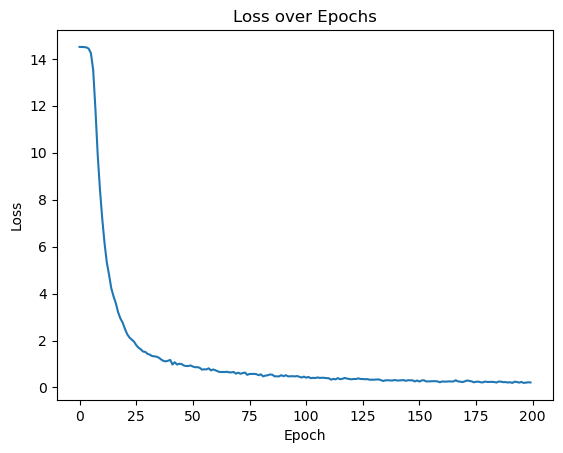

[6 9 3]
[6 9 3]

Accuracy: 0.9722222222222222


In [108]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

# Standardize the features
X = standardize_data(X)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse=False)
y = one_hot_encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
network = NeuralNetwork()
network.add_layer(Layer(64, 128))  # 64 inputs (8x8 images)
network.add_layer(ReLU())
network.add_layer(Dropout(0.25))
network.add_layer(Layer(128, 10))  # 10 classes
network.add_layer(Softmax())

# Train the network
network.train(X_train, y_train, epochs=200, learning_rate=0.01, batch_size=10)

network.plot_loss()

# Evaluate the performance of the model
y_pred = network.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test)
print(y_pred[:3])
print(y_test[:3])
print(f"\nAccuracy: {accuracy}")

[[0]
 [0]
 [0]]
Epoch 1/100 --- Loss: 2.670077130784485
Epoch 11/100 --- Loss: 1.6236811708023087
Epoch 21/100 --- Loss: 0.8472734063163732
Epoch 31/100 --- Loss: 1.2805981988675894
Epoch 41/100 --- Loss: 1.4121932019844434
Epoch 51/100 --- Loss: 0.4453412269583143
Epoch 61/100 --- Loss: 1.3955508112074653
Epoch 71/100 --- Loss: 1.2169516835851386
Epoch 81/100 --- Loss: 1.797986004005552
Epoch 91/100 --- Loss: 1.068539184972588


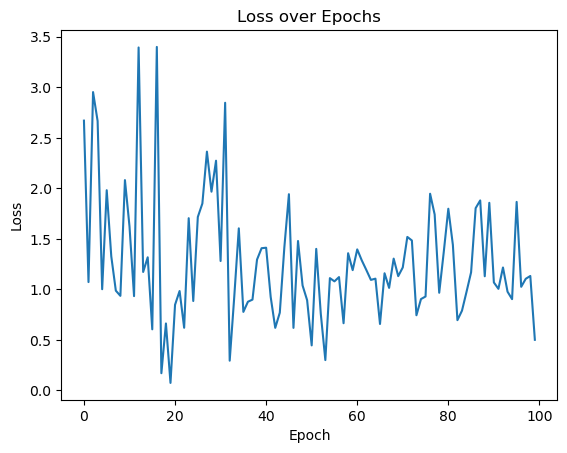

[[1]
 [0]
 [0]]
[[1.38341843e-01]
 [2.29026016e-08]
 [4.06202871e-04]]

Accuracy: 0.0


In [30]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

X = dataset.data
y = dataset.target
y = y.reshape(-1, 1)
print(y[:3])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
network = NeuralNetwork()
network.add_layer(Layer(X_train.shape[1], 128))  # 64 inputs (8x8 images)
network.add_layer(ReLU())
network.add_layer(Layer(128, 1))  # 1 classes
network.add_layer(Sigmoid())

# Train the network
network.train(X_train, y_train, epochs=100, learning_rate=0.01, batch_size=8)

network.plot_loss()

# Evaluate the performance of the model
y_pred = network.predict(X_test)
print(y_test[:3])
#y_test = np.argmax(y_test, axis=1)
print(y_pred[:3])
accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy}")